In [1]:
!pip uninstall tensorflow tensorflow_gpu protobuf --yes

Uninstalling tensorflow-1.4.0:
  Successfully uninstalled tensorflow-1.4.0
Cannot uninstall requirement tensorflow-gpu, not installed
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install protobuf==3.6.0 tensorflow==1.8.0 tensorflow_gpu==1.8.0 --no-cache-dir

    100% |████████████████████████████████| 7.1MB 28.6MB/s ta 0:00:01
    100% |████████████████████████████████| 49.1MB 73.3MB/s ta 0:00:01
    100% |████████████████████████████████| 216.3MB 76.3MB/s ta 0:00:01   30% |█████████▉                      | 66.3MB 66.2MB/s eta 0:00:03    92% |█████████████████████████████▌  | 199.1MB 71.5MB/s eta 0:00:01
    100% |████████████████████████████████| 3.1MB 73.4MB/s ta 0:00:01
    100% |████████████████████████████████| 9.3MB 76.3MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 63.8MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 44.4MB/s ta 0:00:01    79% |█████████████████████████▍      | 706kB 68.7MB/s eta 0:00:01
  Found existing installation: protobuf 3.4.1
    Uninstalling protobuf-3.4.1:
      Successfully uninstalled protobuf-3.4.1
  Found existing installation: html5lib 1.0b10
    Uninstalling html5lib-1.0b10:
      Successfully uninstalled html5lib-1.0b10
  Running setup.py install for html5lib ... do

In [1]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg
dynrnn = tf.nn.dynamic_rnn
bidynrnn = tf.nn.bidirectional_dynamic_rnn

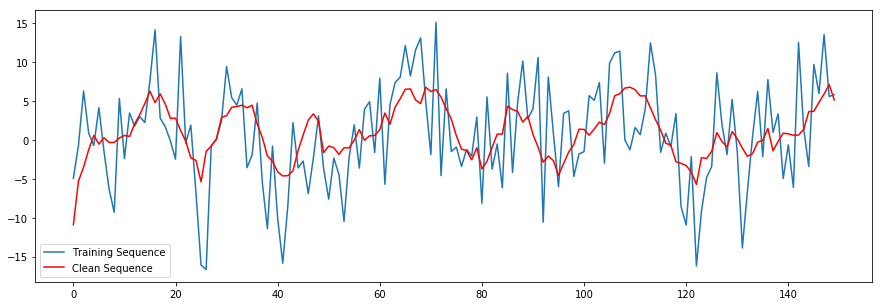

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.log(1 + np.exp(x)) + 1e-5

np.random.seed(1)
H = 140; T = 300; N = 1000; training_size = 900
h = np.zeros((N, T + 1, H))
y = np.zeros((N, T + 1, 1))
sigma_c = 5.3
sigma_b = 1.5

A = 0.8 * np.random.randn(H, H)
R = scipy.linalg.expm(A - A.T)
B = 0.2 * np.random.randn(1, H)
b = 0.5 * np.random.randn(H, 1)
c = 1 * np.random.randn(H, 1)
bias_h = np.random.rand(1, H)
d = 0.01 * np.random.rand(H, 1)

for i in range(1, T + 1):
    h[:, i, :] = np.tanh(np.dot(h[:, i-1, :], R) + np.dot(y[:, i-1], B)) + 0.7 * h[:, i-1, :] + bias_h
    y[:, i] = (1 * np.dot(h[:, i, :], b) + np.tanh(np.dot(h[:, i, :], c)) - 1 
               + 3 * softplus(np.tanh(np.dot(h[:, i, :], d)) - 2) *
               np.random.randn(N, 1))

y = y[:, 1:]
y = y - np.mean(y, 1, keepdims=True)
fig, ax = plt.subplots(1,1,figsize=(15, 5))
y_tilde = (y 
           + sigma_c
           * np.random.randn(N, T, 1))

seq_length = 150
training_data = y_tilde[:training_size]
testing_data = y_tilde[training_size:]

plt.plot(y_tilde[0, :seq_length], label='Training Sequence');
plt.plot(y[0, :seq_length], 'r', label='Clean Sequence');
plt.legend();

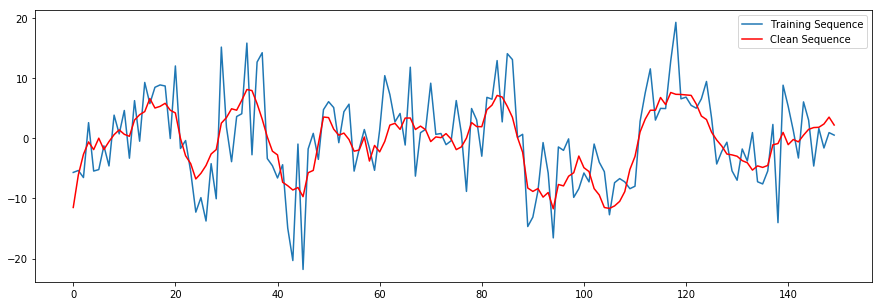

In [3]:
idx = np.random.randint(0, 100)
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[idx, :seq_length], label='Training Sequence');
plt.plot(y[idx, :seq_length], 'r', label='Clean Sequence');
plt.legend();

In [4]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [6]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._layer_mu = tf.layers.Dense(self._event_size)
        self._layer_sigma = tf.layers.Dense(self._event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = self._layer_mu(hidden)
        std = self._layer_sigma(hidden)
        return (mean, std), state

class CellWithState(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, reuse=None):
        self._cell = cell
    
    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._cell.output_size, self._cell.state_size)
    
    def call(self, inputs, state):
        outputs, state = self._cell(inputs, state)
        return (outputs, state), state
        
class SamplingCell(tf.contrib.rnn.RNNCell):

    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.MultivariateNormalDiag(mean, std).sample()
        return (mean, std, sample), (state, sample)

In [526]:
class BayesianRobustARGenerator(object):
    """
    Model to test
    """

    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size, w_lambda=0.):
        self._data = data                                               # B x T x D
        self._B = batch_size                                            # B - batch size
        self._T = seq_length                                            # T - number of time steps
        self._D = 1                                                     # D - dimensionality of each time step
        self._H = n_hidden                                              # H - dimensionality of RNN hidden states
        self._Sz = n_samples                                            # Sz - number of samples from the posterior
        self._Z = 20                                                    # Z - dimensionality of the global latent z
        self._mu_W = np.ones((self._H * self._D))                       # Prior mean for W
        self._Sigma_W = np.diag(np.ones((self._H * self._D)))           # Prior covariance for W
        
        self.initialise_variables                                       #
        
        self.q_y = self.make_posterior_y                                # posterior q(y|x)
        self.p_y = self.make_transitional                               # prior p(y|z) under q(z) and q(y)        
        self.make_reconstruction
        self.compute_elbo
        
        self.E_step
        self.M_step
        
#         self.q_psi_y = self.make_posterior_forward
#         self.p_y_forw, self.p_y_bar = self.make_rnn_forward
#         self.make_reconstruction_forward
#         self.compute_elbo_forward
        
#         self.E_step_forward
#         self.M_step_forward

    @define_scope
    def initialise_variables(self):
        # Initialises all variables and RNN cells
        self._cell = tfn.GRUBlockCell(self._H)
        self._state_cell = CellWithState(self._cell)
        self._gauss_cell = GaussianCell(self._cell, self._D, reg_lambda=self._w_lambda)
        
        self._post_cell_f = tfn.GRUBlockCell(self._H)
        self._post_cell_b = tfn.GRUBlockCell(self._H)
        
        self._most_likely_pred = tf.get_variable(shape=(1, 30, self._D), name='best_forward_sequence',
                                                 initializer=tf.constant_initializer(0))
        
        self._optimiser = tf.train.AdamOptimizer(0.001)

    @define_scope
    def make_posterior_y(self):
        (out_f, out_b), _ = bidynrnn(self._post_cell_f, self._post_cell_b, inputs=self._data, dtype=tf.float32)
        hidden = tf.concat([out_f, out_b], 2)
        means = tf.layers.dense(hidden, self._D)
        stds = tf.layers.dense(hidden, self._D, tf.nn.softplus) + 1e-5
        return tfd.MultivariateNormalDiag(means, stds)

    @define_scope
    def make_transitional(self):
        self._code_y = self.q_y.sample(self._Sz)
        code_y = tf.reshape(self._code_y, [-1, self._T, self._D])
        inputs = tf.concat([tf.zeros((self._B * self._Sz, 1, self._D)), code_y[:, :-1]], 1)
        hiddens, _ = dynrnn(self._state_cell, inputs=inputs, dtype=tf.float32)
        self._hiddens = tf.reshape(hiddens, [self._Sz, self._B, self._T, self._H])
        p_w = tfd.MultivariateNormalFullCovariance(self._mu_W, self._Sigma_W)
        W = p_w.sample()
        means = tf.tensordot(hiddens, W, 1)
        means = tf.reshape(means, [self._Sz, self._B, self._T, self._D])
        stds = self._std_layer(hiddens) + 1e-5
        stds = tf.reshape(stds, [self._Sz, self._B, self._T, self._D])
        return tfd.MultivariateNormalDiag(means, stds)

    @define_scope
    def make_kl_y(self):
        return tf.reduce_sum(tfd.kl_divergence(self.q_y, self.p_y)) / (self._Sz * self._B)

    @define_scope
    def make_reconstruction(self):
        data = tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1))
        self._gen_std = tf.nn.softplus(tf.get_variable(shape=(), name='gen_std', 
                                       initializer=tf.constant_initializer(1))) + 1e-5
        
        mean = self._code_y
        gen_prob = tfd.MultivariateNormalDiag(mean, scale_identity_multiplier=self._gen_std)

        return tf.reduce_sum(gen_prob.log_prob(data)) / (self._Sz * self._B)

    @define_scope
    def compute_elbo(self):
        kl_y = self.make_kl_y
        reconstruction = self.make_reconstruction
        
        l2_loss = tf.losses.get_regularization_loss()
        loss = reconstruction - kl_y - l2_loss
        return loss, kl_y, reconstruction
    
    @define_scope
    def E_step(self):
        # Optimses the ELBO function
        vars_e = [v for v in tf.trainable_variables() if 'make_posterior' in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0], var_list=vars_e))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def M_step(self):
        # Optimses the ELBO function
        vars_m = [v for v in tf.trainable_variables() if 'make_posterior' not in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0], var_list=vars_m))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def posterior_update(self):
        mu_y = self.q_y.mean()
        sigma_y = self.q_y.covariance()
        precision + = tf.tensordot(tf.transpose(self._hiddens, [2,0,1]), self._hiddens, 2)
        hidden_sq = (tf.tensordot(tf.transpose(self._hiddens, [2,0,1]), mu_y, 2))
        
        
        precision /= (tf.square(self._gen_std))
        
        
        self._Sigma = tf.matrix_inverse(np.diag(np.ones((self._D * self._D))) + precision)
        first_order_term = (tf.reduce_sum(self._data * mu_y, [0, 1])/(tf.square(self._gen_std)))[None, ...]
        first_order_term += tf.ones((1, 1))
        self._mu = tf.matmul(self._Sigma, first_order_term)        
        return mu_y

#     @define_scope
#     def make_generative_forward(self):
#         return tfd.MultivariateNormalDiag(self._most_likely_pred, scale_identity_multiplier=self._gen_std)   
    
#     @define_scope
#     def make_posterior_forward(self):
#         inputs = tf.concat([self._data, self.make_generative_forward.sample()], 1)
#         (out_f, out_b), _ = bidynrnn(self._post_cell_f, self._post_cell_b, inputs=inputs, dtype=tf.float32)
#         hidden = tf.concat([out_f, out_b], 2)
#         means = self._post_layer_means(hidden)[:, :self._T]
#         stds = self._post_layer_stds(hidden)[:, :self._T] + 1e-5
#         return tfd.MultivariateNormalDiag(means, stds)
    
#     @define_scope
#     def make_rnn_forward(self):
#         self._code_y_forw = self.q_y.sample(self._Sz)
#         inputs = tf.concat([tf.zeros((self._Sz, 1, self._D)), self._code_y_forw[:, 0, :-1]], 1)
#         (means_y, stds_y), hT = dynrnn(self._gauss_cell, inputs, dtype=tf.float32)
#         p_y = tfd.MultivariateNormalDiag(means_y, stds_y)
        
#         inputs = tf.concat([self._code_y_forw[:, 0, -1:], 
#                             tf.tile(self._most_likely_pred[:, :-1], (self._Sz, 1, 1))], 1)
#         (means_ybar, stds_ybar), _ = dynrnn(self._gauss_cell, inputs=inputs, initial_state=hT)
#         p_y_bar = tfd.MultivariateNormalDiag(means_ybar, stds_ybar)

#         return p_y, p_y_bar
    
#     @define_scope
#     def make_kl_forward(self):
#         return tf.reduce_sum(tfd.kl_divergence(self.q_psi_y, self.p_y_forw)) / self._Sz
    
#     @define_scope
#     def make_reconstruction_forward(self):
#         forward = tf.tile(self._most_likely_pred, [self._Sz, 1, 1])
#         exp_py = tf.reduce_sum(self.p_y_bar.log_prob(forward)) / self._Sz
        
#         p_x = tfd.MultivariateNormalDiag(self._code_y_forw[:, 0], scale_identity_multiplier=self._gen_std)
#         data = tf.tile(self._data, (self._Sz, 1, 1))
#         exp_px = tf.reduce_sum(p_x.log_prob(data)) / self._Sz
        
#         return exp_px, exp_py
    
#     @define_scope
#     def compute_elbo_forward(self):
#         kl_y = self.make_kl_forward
#         rec_x, rec_y = self.make_reconstruction_forward
#         return rec_x + rec_y - kl_y
    
#     @define_scope
#     def E_step_forward(self):
#         var_e = [v for v in tf.trainable_variables() if 'make_posterior' in v.name]
#         gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo_forward, var_list=var_e))
#         gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
#         return self._optimiser.apply_gradients(zip(gradients, variables))

#     @define_scope
#     def M_step_forward(self):
#         var_m = [v for v in tf.trainable_variables() if 'best_forward_sequence' in v.name]
#         gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo_forward, var_list=var_m))
#         gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
#         return self._optimiser.apply_gradients(zip(gradients, variables))

In [ ]:
tf.reset_default_graph()
Sz = 50 
B = 20 
T = 100 
I = 1000
H = 150
w_lambda = 0.

x_ = tf.placeholder(tf.float32, [None, T, 1])
gen_model = RobustARGenerator(x_, n_hidden=H, n_samples=S, seq_length=T, batch_size=B, w_lambda=w_lambda)

sess = tf.Session()
saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' not in v.name])
sess.run(tf.global_variables_initializer())
elbos = []; kls_z = []; llks = []; test_elbos = []

for i in range(I):
    idx = np.random.randint(0, training_size, B)
    batch = training_data[idx, :T]

    elbo, kl_z, llk = sess.run(gen_model.compute_elbo, {x_: batch})
    elbos.append(elbo); kls_z.append(kl_z); llks.append(llk)
    
    if i % 10 == 0:
        test_idx = np.random.randint(0, testing_data.shape[0], B)
        test_batch = testing_data[test_idx, :T]
        test_elbo, _, _ = sess.run(gen_model.compute_elbo, {x_: test_batch})
        test_elbos.append(test_elbo)
    
    if i % 100 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL (y):', kl_z, 'Reconstruction:', llk)
    
    for _ in range(10):
        sess.run(gen_model.E_step, {x_: batch})
    for _ in range(10):
        sess.run(gen_model.M_step, {x_: batch})

INFO:tensorflow:Scale of 0 disables regularizer.
Iteration: 0 ELBO: -1400.19 KL (y): 37.1692 Reconstruction: -1363.02


In [450]:
saver.save(sess, './experimental_model_no_prediction_no_regulariser.ckpt')

'./experimental_model_no_prediction_no_regulariser.ckpt'

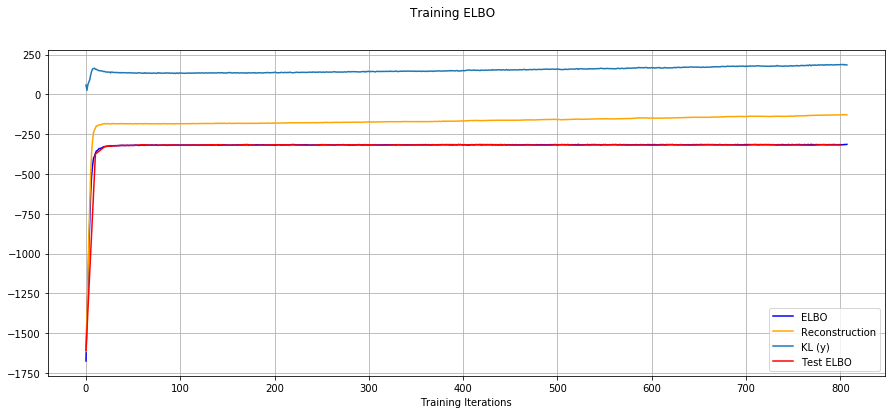

In [435]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(kls_z, label='KL (y)')
plt.plot([10 * i for i in range(len(test_elbos))], test_elbos, 'r', label='Test ELBO')
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
# plt.ylim([-50000, 20000])
plt.legend();
# plt.savefig('robust-seq-vae-training-not-regularised.pdf', bbox_inches='tight')

In [475]:
np.random.seed(0)
idx = np.random.randint(0, testing_data.shape[0], B)
test_batch = testing_data[idx, :T]
prior_means = sess.run(gen_model.p_y.mean(), {x_: test_batch})
post_means = sess.run(gen_model.q_y.mean(), {x_: test_batch})
latents = sess.run(gen_model._code_y, {x_: test_batch})

In [ ]:
plot_idx = np.random.choice(B, 4)
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(25,15))

for e, ax in enumerate(axs.flatten()):
    ax.plot(test_batch[plot_idx[e], :], 'b', label='Noisy Sequence')
    ax.plot(prior_means[0, plot_idx[e]], 'r-', label='Prior Means')
    ax.plot(prior_means[1, plot_idx[e]], 'r-')
    ax.plot(np.reshape(latents, (S, B, T))[0, plot_idx[e]] , 'g', label='Posterior Sample')
    ax.plot(post_means[plot_idx[e]], 'k', label='Posterior Means')
    ax.plot([], [])
    ax.plot(y[training_size + plot_idx[e], :T], label='Clean Signal')
    ax.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.93)
fig.suptitle('Modelling (Robust Seq-VAE)', fontsize=22);
# plt.savefig('robust-seq-vae-modelling-not-regularised.pdf', bbox_inches='tight')

In [7]:
elbos_forward = [];
for i in range(501):   
    elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: test_batch[:1]})    
    
    if i % 100 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward)
        
    for _ in range(10):
        sess.run(gen_model.M_step_forward, {x_: test_batch[:1]})    
    for _ in range(10):
        sess.run(gen_model.E_step, {x_: test_batch[:1]})
        
    elbos_forward.append(elbo_forward)

NameError: name 'sess' is not defined

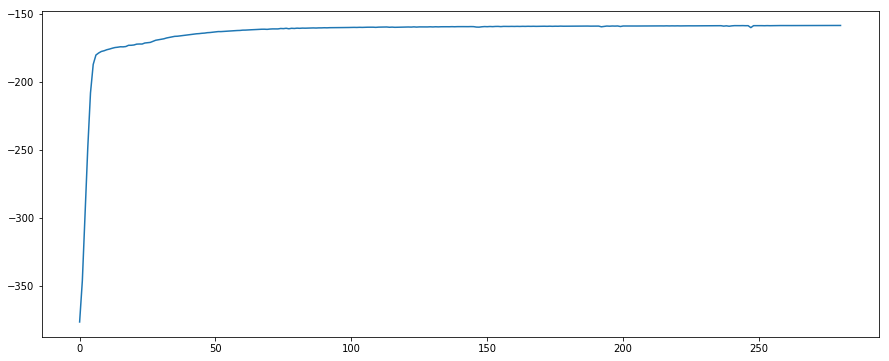

In [462]:
plt.subplots(1,1,figsize=(15,6))
plt.plot(elbos_forward)

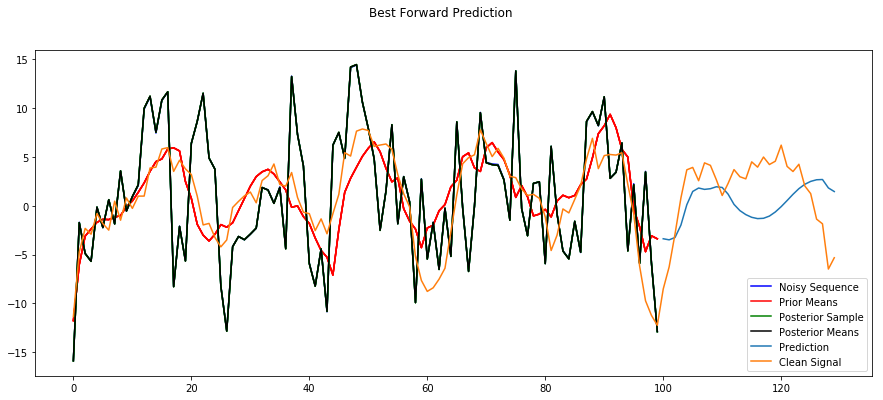

In [518]:
i = 0
latents = sess.run(gen_model._code_y, {x_: test_batch})
continuation = sess.run(gen_model._most_likely_pred, {x_: batch})
fig, axs = plt.subplots(1,1,figsize=(15, 6))
plt.plot(test_batch[i, :], 'b', label='Noisy Sequence')
plt.plot(prior_means[0, i], 'r-', label='Prior Means')
plt.plot(prior_means[1, i], 'r-')
plt.plot(prior_means[2, i], 'r-')
plt.plot(prior_means[3, i], 'r-')
plt.plot(np.reshape(latents, (S, B, T))[1, i] , 'g', label='Posterior Sample')
plt.plot(np.reshape(latents, (S, B, T))[0, i] , 'g')
plt.plot(np.reshape(latents, (S, B, T))[2, i] , 'g')
plt.plot(post_means[i], 'k', label='Posterior Means')
plt.plot([i for i in range(T, T+30)], continuation[0], label='Prediction')
plt.plot(y[training_size + idx[i], :T + 30], label='Clean Signal')
plt.legend()
plt.suptitle("Best Forward Prediction");